Best solution found:
 x = [ 0.0734534  -0.03105145 -0.00208977 -0.04406662 -0.00898485]
 f(x) = 0.008386556803723005


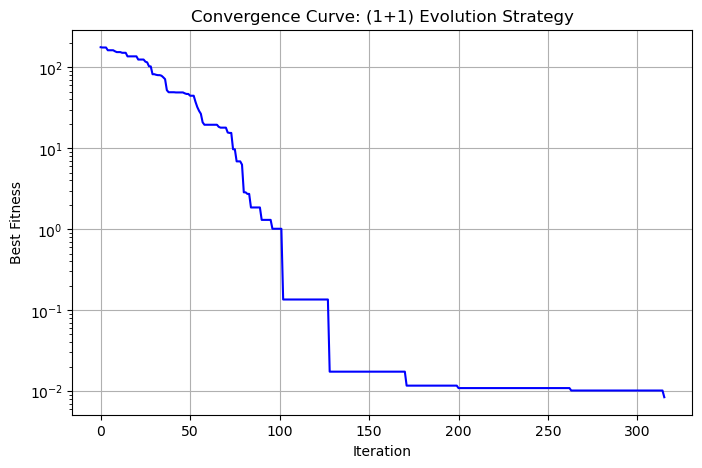

In [92]:
"""
(1+1) Evolution Strategy

Objective:
Minimize the function f(x) = (x)^2

This implementation uses a single parent solution,
generates one offspring per iteration via Gaussian mutation,
and accepts the offspring if it improves fitness.
"""

import numpy as np
import matplotlib.pyplot as plt

# --------- Problem Definition ---------
def fitness(x):
    """Objective function to minimize: Sphere function."""
    return np.sum(x**2)

# --------- Algorithm Parameters ---------
bounds = (-10, 10)            # Search space bounds
sigma = 0.5                   # Initial mutation step size
tolerance = 1e-6              # Stopping criterion for movement
max_iterations = 10000        # Max number of generations
#dimension =  5                # <--- Change this for n-dimensions

# --------- Initialization ---------
def initialize_solution(bounds, dimension):
    """Generate a random initial solution within bounds in n dimensions."""
    x0 = np.random.uniform(bounds[0], bounds[1], size=dimension)
    y0 = fitness(x0)
    return x0, y0

# --------- (1+1) Evolution Strategy ---------
def evolution_strategy(bounds, sigma, tolerance, max_iterations, dimension):
    """(1+1) ES with self-adaptive step-size for n-dimensional optimization."""
    x0, y0 = initialize_solution(bounds, dimension)
    path = [(x0.copy(), y0)]
    best_fitness_history = [y0]

    for iteration in range(max_iterations):
        # Mutation
        x1 = x0 + np.random.normal(0, sigma, size=dimension)

        # Project to bounds
        x1 = np.clip(x1, bounds[0], bounds[1])
        y1 = fitness(x1)

        # Selection + self-adaptive sigma
        if y1 < y0:
            x0, y0 = x1, y1
            if dimension == 1:
                path.append((x0[0], y0))
            else:
                path.append((x0.copy(), y0))
            sigma *= 1.01
        else:
            sigma *= 0.99

        sigma = max(sigma, 1e-8)  # Allow even smaller sigma
        
        best_fitness_history.append(y0)

        # New stopping condition: very low fitness
        if y0 < 1e-2:
            break

    return path, best_fitness_history

# --------- (mu+1) Evolution Strategy ---------
def evolution_strategy_mu_plus_1(bounds, sigma, tolerance, max_iterations, dimension, mu):
    """
    (μ+1) Evolution Strategy with Self-Adaptive Step-Size for n-dimensional optimization.

    - Population of μ parents.
    - Each generation generates 1 offspring.
    - Select μ best individuals from parents + offspring.
    """
    # Initialize μ parents
    parents = np.random.uniform(bounds[0], bounds[1], size=(mu, dimension))
    parents_fitness = np.array([fitness(p) for p in parents])

    best_fitness_history = [np.min(parents_fitness)]

    for iteration in range(max_iterations):
        # Select a parent randomly
        idx = np.random.randint(mu)
        parent = parents[idx]

        # Mutation
        child = parent + np.random.normal(0, sigma, size=dimension)

        # Project to bounds
        child = np.clip(child, bounds[0], bounds[1])
        child_fitness = fitness(child)

        # Combine parents + child
        combined = np.vstack((parents, child))
        combined_fitness = np.append(parents_fitness, child_fitness)

        # Select the best μ individuals
        best_indices = np.argsort(combined_fitness)[:mu]
        parents = combined[best_indices]
        parents_fitness = combined_fitness[best_indices]

        # Self-adaptive sigma
        if child_fitness < parents_fitness[0]:
            sigma *= 1.01
        else:
            sigma *= 0.99

        sigma = max(sigma, 1e-8)  # Minimum step size

        best_fitness_history.append(np.min(parents_fitness))

        # Stopping condition
        if np.min(parents_fitness) < 1e-2:
            break

    best_parent_idx = np.argmin(parents_fitness)
    best_solution = parents[best_parent_idx]
    best_fitness = parents_fitness[best_parent_idx]

    return best_solution, best_fitness, best_fitness_history

# --------- (mu+lambda) Evolution Strategy ---------
def evolution_strategy_mu_plus_lambda(bounds, sigma, tolerance, max_iterations, dimension, mu, lambd):
    """
    (μ+λ) Evolution Strategy with Self-Adaptive Step-Size for n-dimensional optimization.

    - Population of μ parents generates λ offspring.
    - Both parents and offspring compete together.
    - Select μ best individuals for next generation (elitist strategy).
    """
    # Initialize μ parents
    parents = np.random.uniform(bounds[0], bounds[1], size=(mu, dimension))
    parents_fitness = np.array([fitness(p) for p in parents])

    best_fitness_history = [np.min(parents_fitness)]

    for iteration in range(max_iterations):
        # Generate offspring
        offspring = []
        offspring_fitness = []
        
        for _ in range(lambd):
            # Select a parent randomly
            idx = np.random.randint(mu)
            parent = parents[idx]
            
            # Mutation
            child = parent + np.random.normal(0, sigma, size=dimension)
            child = np.clip(child, bounds[0], bounds[1])  # Clip to bounds

            offspring.append(child)
            offspring_fitness.append(fitness(child))
        
        offspring = np.array(offspring)
        offspring_fitness = np.array(offspring_fitness)

        # Combine parents + offspring
        combined = np.vstack((parents, offspring))
        combined_fitness = np.append(parents_fitness, offspring_fitness)

        # Select the best μ individuals
        best_indices = np.argsort(combined_fitness)[:mu]
        new_parents = combined[best_indices]
        new_parents_fitness = combined_fitness[best_indices]

        # Self-adaptive sigma based on improvement
        if np.min(new_parents_fitness) < np.min(parents_fitness):
            sigma *= 1.01
        else:
            sigma *= 0.99

        sigma = max(sigma, 1e-8)  # Minimum step size

        parents = new_parents
        parents_fitness = new_parents_fitness
        best_fitness_history.append(np.min(parents_fitness))

        # Stopping condition
        if np.min(parents_fitness) < 1e-2:
            break

    best_parent_idx = np.argmin(parents_fitness)
    best_solution = parents[best_parent_idx]
    best_fitness = parents_fitness[best_parent_idx]

    return best_solution, best_fitness, best_fitness_history

# --------- Visualization ---------
def plot_convergence(fitness_history, strategy_name=strategy_name):
    """Plot the convergence curve of best fitness over iterations."""
    plt.figure(figsize=(8, 5))
    plt.plot(fitness_history, 'b-')
    plt.xlabel('Iteration')
    plt.ylabel('Best Fitness')
    plt.title(f'Convergence Curve: {strategy_name}')
    plt.yscale('log')
    plt.grid(True)
    plt.show()


# --------- Main Execution ---------
if __name__ == "__main__":
    dimension = 5  # Can be 1D, 5D, 10D, etc.
    strategy_name = "(1+1) Evolution Strategy"
    path, fitness_history = evolution_strategy(bounds, sigma, tolerance, max_iterations, dimension)
    print(f"Best solution found:\n x = {path[-1][0]}\n f(x) = {path[-1][1]}")
    plot_convergence(fitness_history, strategy_name=strategy_name)


Best solution found:
 x = [ 0.20012925  0.01881131 -0.28829599  0.2289474  -0.15458054]
 f(x) = 0.19983221885773172


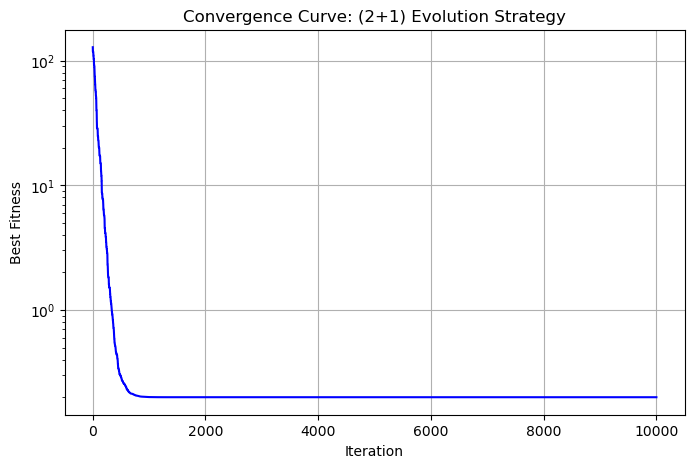

In [95]:
if __name__ == "__main__":
    mu = 2  # Number of parents
    dimension = 5  # Can be 1D, 5D, 10D, etc.
    strategy_name = f"({mu}+1) Evolution Strategy"

    best_solution, best_fitness, fitness_history = evolution_strategy_mu_plus_1(bounds, sigma, tolerance, max_iterations, dimension, mu)

    print(f"Best solution found:\n x = {best_solution}\n f(x) = {best_fitness}")
    plot_convergence(fitness_history, strategy_name=strategy_name)

Best solution found:
 x = [ 0.01025837 -0.06250278 -0.01033694  0.00108542  0.01505612]
 f(x) = 0.004346548962132379


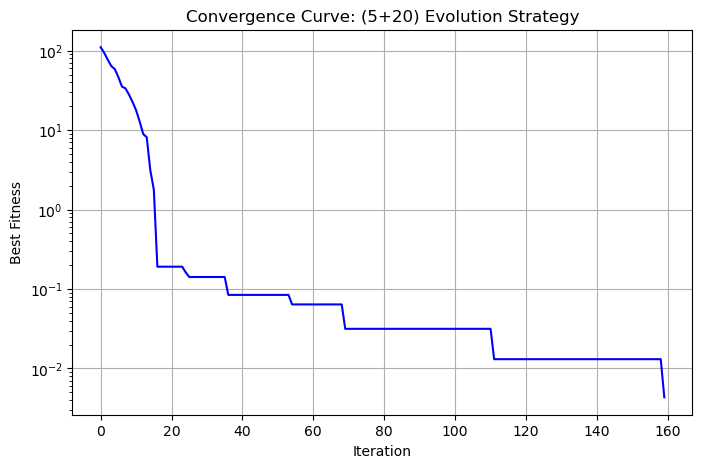

In [94]:
if __name__ == "__main__":
    mu = 5         # Number of parents
    lambd = 20     # Number of offspring
    dimension = 5  # Can be 1D, 5D, 10D, etc.
    strategy_name = f"({mu}+{lambd}) Evolution Strategy"

    best_solution, best_fitness, fitness_history = evolution_strategy_mu_plus_lambda(bounds, 
                                                                                     sigma, 
                                                                                     tolerance, 
                                                                                     max_iterations, 
                                                                                     dimension, 
                                                                                     mu,
                                                                                    lambd)

    print(f"Best solution found:\n x = {best_solution}\n f(x) = {best_fitness}")
    plot_convergence(fitness_history, strategy_name=strategy_name)